## 패키지

In [3]:
from pandas import DataFrame,read_csv,read_excel,merge,melt,pivot_table
import numpy
from matplotlib import pyplot as plt
import seaborn as sb
import sys
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from factor_analyzer.factor_analyzer import calculate_kmo

## 폰트

In [4]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.unicode_minus"] = False

### 데이터 불러오기

In [5]:
origin=read_excel('행정동병합테스트2_최종.xlsx')
origin.head()

,시도명,시군구코드,시군구명,행정동코드,읍면동명,면적 (k㎡),서울시전체면적_대비_구성비 (%),인구_수,아동인구(0~9세),65세이상인구,...,사업체_수,개소 (공영+민영),면수 (공영+민영),행정동별_공원+산_수,하천및한강여부,사회복지시설_수,공공체육시설_수,문화시설_수,학교_수,보육시설
0,서울특별시,11110,종로구,1111051500,청운효자동,2.57,0.42,11818,612,2154,...,992,668,4592,2,0,5,10,6,8,4
1,서울특별시,11110,종로구,1111053000,사직동,1.23,0.20,9355,488,1808,...,3532,362,12605,3,0,1,8,13,2,11
2,서울특별시,11110,종로구,1111054000,삼청동,1.49,0.25,2642,108,626,...,708,343,2237,1,0,0,2,31,2,3
3,서울특별시,11110,종로구,1111055000,부암동,2.27,0.38,9536,385,1814,...,558,596,3533,1,1,4,5,5,4,3
4,서울특별시,11110,종로구,1111056000,평창동,8.87,1.47,17858,1033,3495,...,747,1617,9390,0,1,11,5,11,4,3


## 데이터 복사

In [6]:
df = origin.copy()

### 데이터 타입 및 이상치, 결측치 확인

In [7]:
df.dtypes

시도명                    object
시군구코드                   int64
시군구명                   object
행정동코드                   int64
읍면동명                   object
면적 (k㎡)               float64
서울시전체면적_대비_구성비 (%)    float64
인구_수                    int64
아동인구(0~9세)              int64
65세이상인구                 int64
장애인_인구                  int64
인구밀도(1k㎡당)            float64
행정동내_지하철역_수             int64
행정동내_의료기관               int64
사업체_수                   int64
개소 (공영+민영)              int64
면수 (공영+민영)              int64
행정동별_공원+산_수             int64
하천및한강여부                 int64
사회복지시설_수                int64
공공체육시설_수                int64
문화시설_수                  int64
학교_수                    int64
보육시설                    int64
dtype: object

In [8]:
df.isna().sum()

시도명                   0
시군구코드                 0
시군구명                  0
행정동코드                 0
읍면동명                  0
면적 (k㎡)               0
서울시전체면적_대비_구성비 (%)    0
인구_수                  0
아동인구(0~9세)            0
65세이상인구               0
장애인_인구                0
인구밀도(1k㎡당)            0
행정동내_지하철역_수           0
행정동내_의료기관             0
사업체_수                 0
개소 (공영+민영)            0
면수 (공영+민영)            0
행정동별_공원+산_수           0
하천및한강여부               0
사회복지시설_수              0
공공체육시설_수              0
문화시설_수                0
학교_수                  0
보육시설                  0
dtype: int64

> 결측치 없음.

In [9]:
results = []
for column in df.columns:
    zero_count = df.loc[df[column] == 0].shape[0]
    number_count = df.loc[df[column] != 0].shape[0]
    results.append({
        '변수': column,
        '0 값인 수': zero_count,
        '0 값이 아닌 수': number_count
    })
result_df = DataFrame(results)
result_df

,변수,0 값인 수,0 값이 아닌 수
0,시도명,0,426
1,시군구코드,0,426
2,시군구명,0,426
3,행정동코드,0,426
4,읍면동명,0,426
5,면적 (k㎡),0,426
6,서울시전체면적_대비_구성비 (%),0,426
7,인구_수,0,426
8,아동인구(0~9세),0,426
9,65세이상인구,0,426


> 0값이 0이 아닌 값보다 많은 변수는 존재하지만 실제 조사 데이터이고 군집(clustering)을 사용할 계획이므로 정상 값으로 판단.

## 기초통계량 확인


In [10]:
df.describe()

,시군구코드,행정동코드,면적 (k㎡),서울시전체면적_대비_구성비 (%),인구_수,아동인구(0~9세),65세이상인구,장애인_인구,인구밀도(1k㎡당),행정동내_지하철역_수,...,사업체_수,개소 (공영+민영),면수 (공영+민영),행정동별_공원+산_수,하천및한강여부,사회복지시설_수,공공체육시설_수,문화시설_수,학교_수,보육시설
count,426.000000,4.260000e+02,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,...,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,11433.521127,1.143415e+09,1.420751,0.234836,22697.406103,1247.492958,3914.659624,919.990610,23034.273976,0.741784,...,1907.269953,720.028169,10567.781690,0.302817,0.776995,5.784038,2.978873,1.870892,3.488263,11.061033
std,192.086184,1.920776e+07,1.569773,0.259592,9009.117334,773.747204,1595.815022,490.919804,11427.588087,0.991251,...,1909.412343,527.175416,7181.650766,0.565554,0.416751,4.523958,4.145816,6.832431,2.785019,6.360617
min,11110.000000,1.111052e+09,0.230000,0.040000,73.000000,1.000000,11.000000,3.000000,79.347826,0.000000,...,0.000000,9.000000,193.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11260.000000,1.126066e+09,0.670000,0.110000,16829.750000,717.250000,2844.750000,562.750000,13944.578947,0.000000,...,935.500000,299.000000,6102.500000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,7.000000
50%,11440.000000,1.144064e+09,0.975000,0.160000,22067.000000,1061.500000,3717.000000,817.500000,23208.949275,0.000000,...,1396.000000,619.000000,8621.500000,0.000000,1.000000,5.000000,1.000000,1.000000,3.000000,10.000000
75%,11612.500000,1.161306e+09,1.490000,0.250000,27773.750000,1594.750000,4842.750000,1215.500000,31624.963235,1.000000,...,2085.000000,1066.250000,13132.500000,1.000000,1.000000,8.000000,4.000000,2.000000,5.000000,14.000000
max,11740.000000,1.174070e+09,12.680000,2.100000,55034.000000,6505.000000,8750.000000,3649.000000,56905.000000,7.000000,...,15691.000000,3162.000000,53019.000000,3.000000,1.000000,27.000000,39.000000,108.000000,15.000000,39.000000


In [13]:
df1 = df.copy()
df1 = df1.drop(['시도명','시군구코드','시군구명','행정동코드','읍면동명'],axis=1)
df1.columns

Index(['면적 (k㎡)', '서울시전체면적_대비_구성비 (%)', '인구_수', '아동인구(0~9세)', '65세이상인구',
       '장애인_인구', '인구밀도(1k㎡당)', '행정동내_지하철역_수', '행정동내_의료기관', '사업체_수',
       '개소 (공영+민영)', '면수 (공영+민영)', '행정동별_공원+산_수', '하천및한강여부', '사회복지시설_수',
       '공공체육시설_수', '문화시설_수', '학교_수', '보육시설'],
      dtype='object')

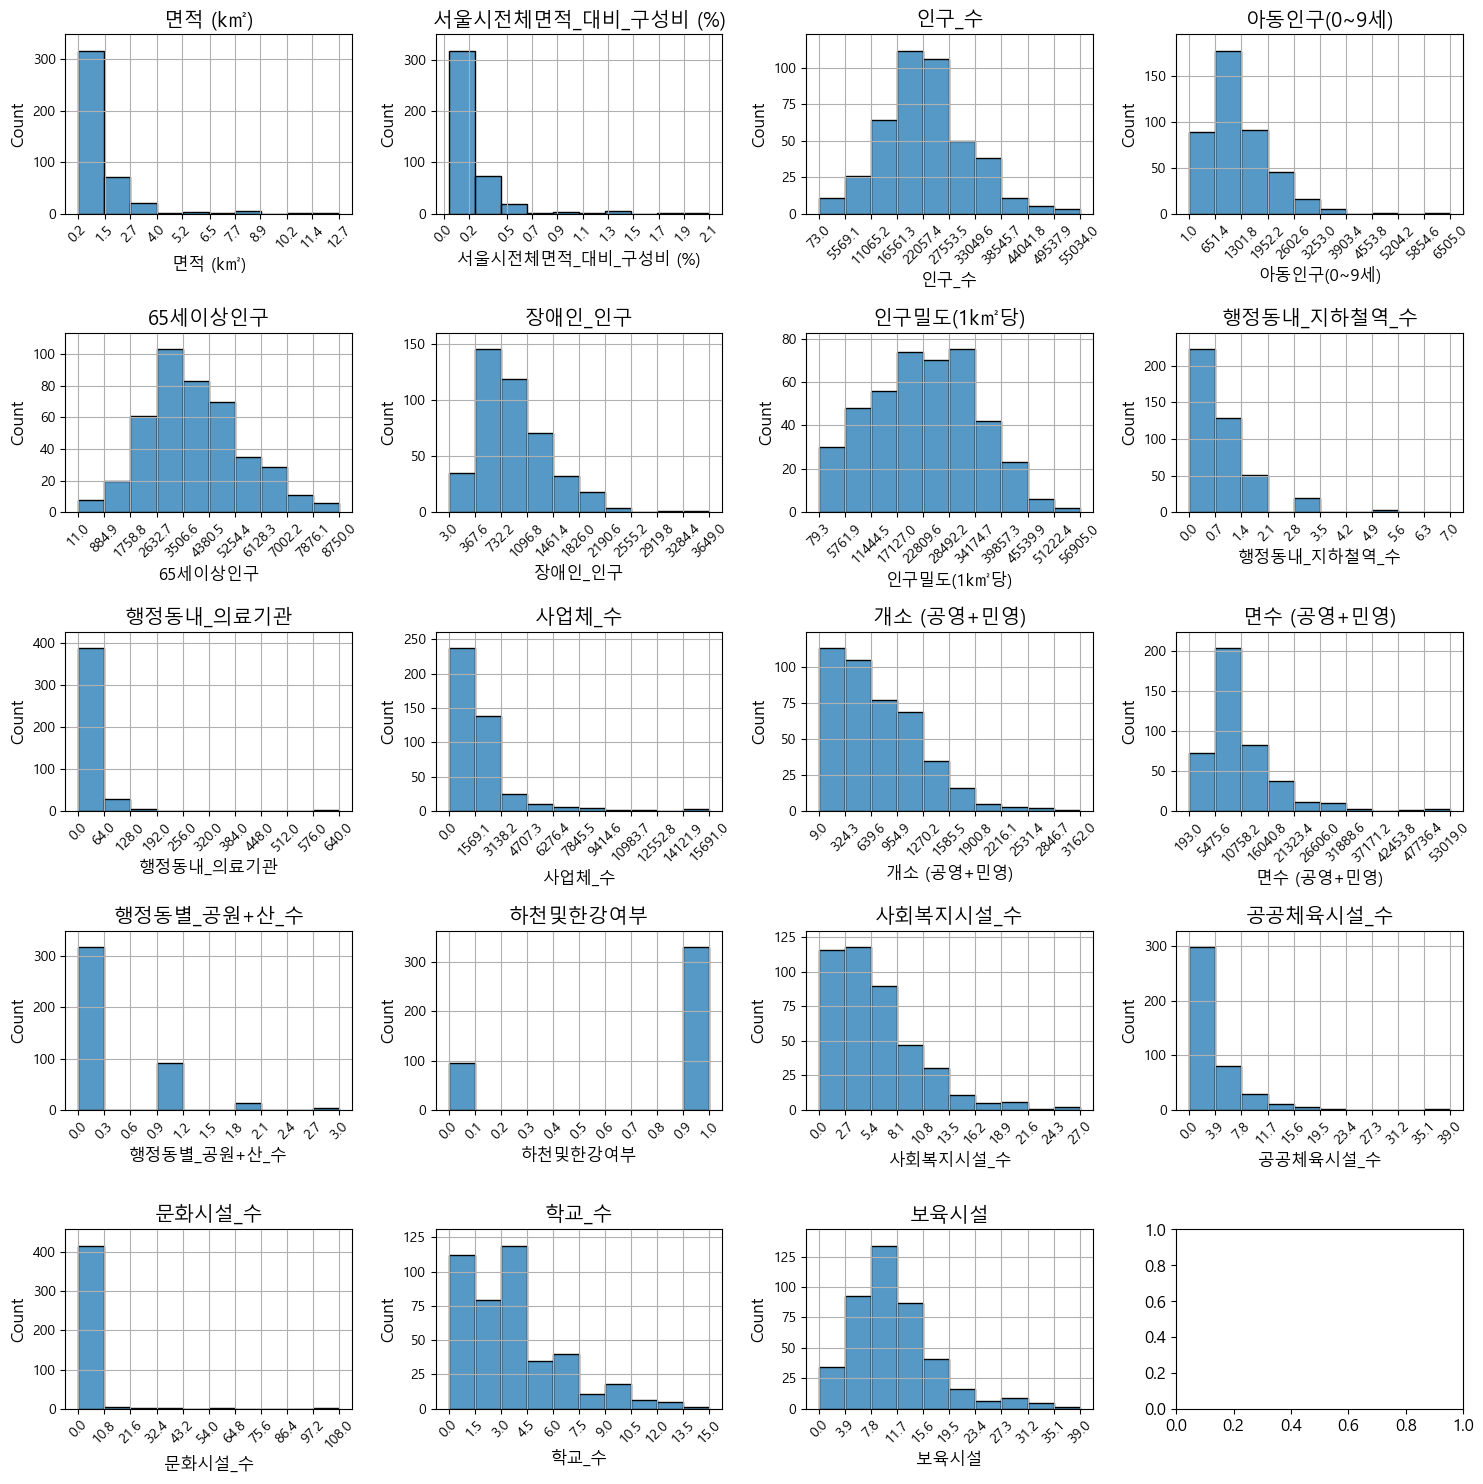

In [18]:
import numpy as np

# 이상치 확인 전
# 데이터를 정리해서 볼 수 있도록 도수분포표(히스토그램) 확인

# 히스토그램과 bins(구간) 설정
num_bins = 10 
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))  # 5x3 서브플롯 생성

for ax, column in zip(axes.flat, df1.columns):
    hist, bins = np.histogram(df1[column], bins=num_bins)
    bins2 = np.round(bins, 1)

    sb.histplot(data=df1, x=column, bins=num_bins, kde=False, ax=ax) #확률밀도곡선 미표시(티가 안 남)
    ax.set_title(column)  # 각 subplot의 제목 설정
    ax.set_xticks(bins2)  # x축 눈금 설정
    ax.set_xticklabels(bins2, rotation=45, fontsize=10)  # x축 눈금 라벨(각도 45도), 폰트 설정
    ax.yaxis.set_tick_params(labelsize=10) #y축 폰트 설정

    # y축 범위 설정(여유 범위를 넣어야 가독성이 좋아짐)
    y_max = hist.max() + hist.max() * 0.1  # 최대 도수에 10% 여유를 더한 값으로 y축 최댓값 설정
    ax.set_ylim(0, y_max)  # y축 범위 설정
    ax.grid(True) # 격자 표시

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

## 이상치 확인

반복문과 sub plot을 이용해 regplot 조회

> 역세권이 중요한 만큼 '행정동내_지하철역_수'를 종속변수로

In [20]:
df1.columns

Index(['면적 (k㎡)', '서울시전체면적_대비_구성비 (%)', '인구_수', '아동인구(0~9세)', '65세이상인구',
       '장애인_인구', '인구밀도(1k㎡당)', '행정동내_지하철역_수', '행정동내_의료기관', '사업체_수',
       '개소 (공영+민영)', '면수 (공영+민영)', '행정동별_공원+산_수', '하천및한강여부', '사회복지시설_수',
       '공공체육시설_수', '문화시설_수', '학교_수', '보육시설'],
      dtype='object')

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26088\1503720172.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout() # 그래프 간격 조정


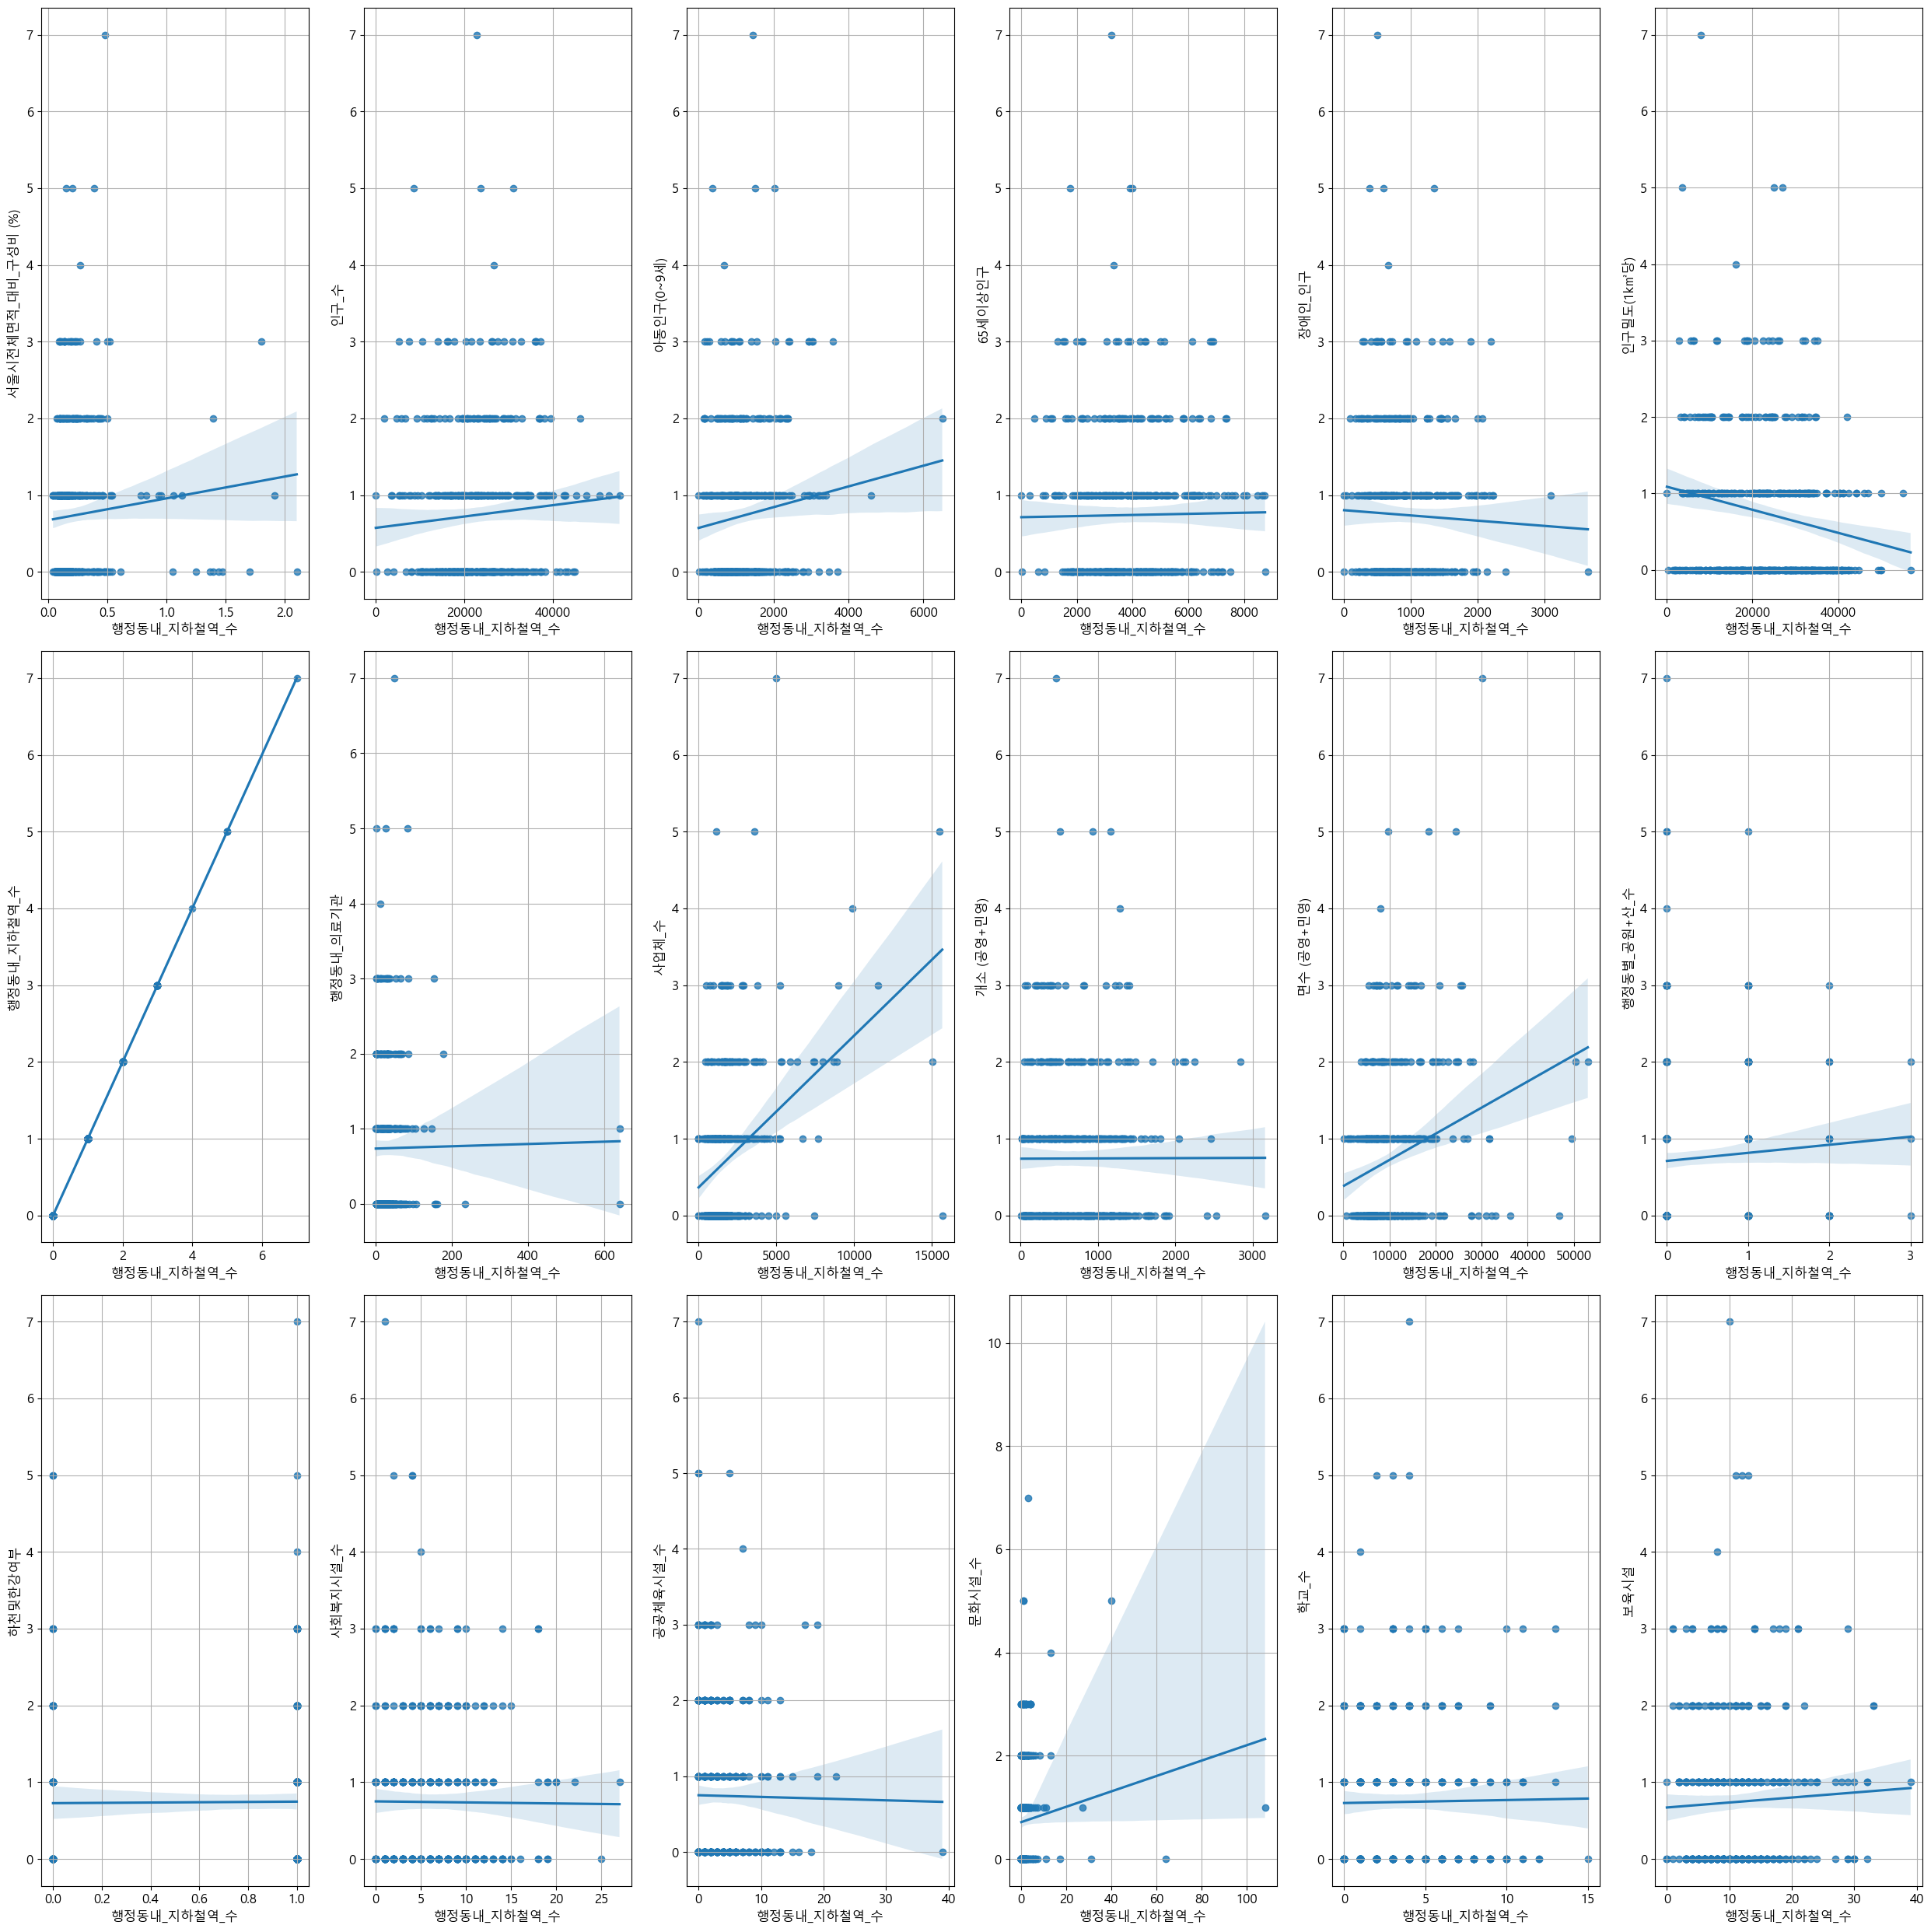

In [28]:
# index = 0부터 시작하면 '총생활비'-'총생활비' 그래프도 그리기 때문에 1부터 시작
columns = list(df1.columns)[1:]

fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(25, 25))

# 종속변수 설정
dependent_variable = '행정동내_지하철역_수'

for i, c in enumerate(columns):
    row, col = divmod(i, 6)
    sb.regplot(data=df1, y=dependent_variable, x=c, ax=ax[row, col])
    ax[row, col].set_xlabel(dependent_variable)
    ax[row, col].set_ylabel(c)
    plt.tight_layout() # 그래프 간격 조정
    ax[row, col].grid() # 격자표시

plt.show()
plt.close()

## 반복문과 sub plot을 이용해 boxplot 조회

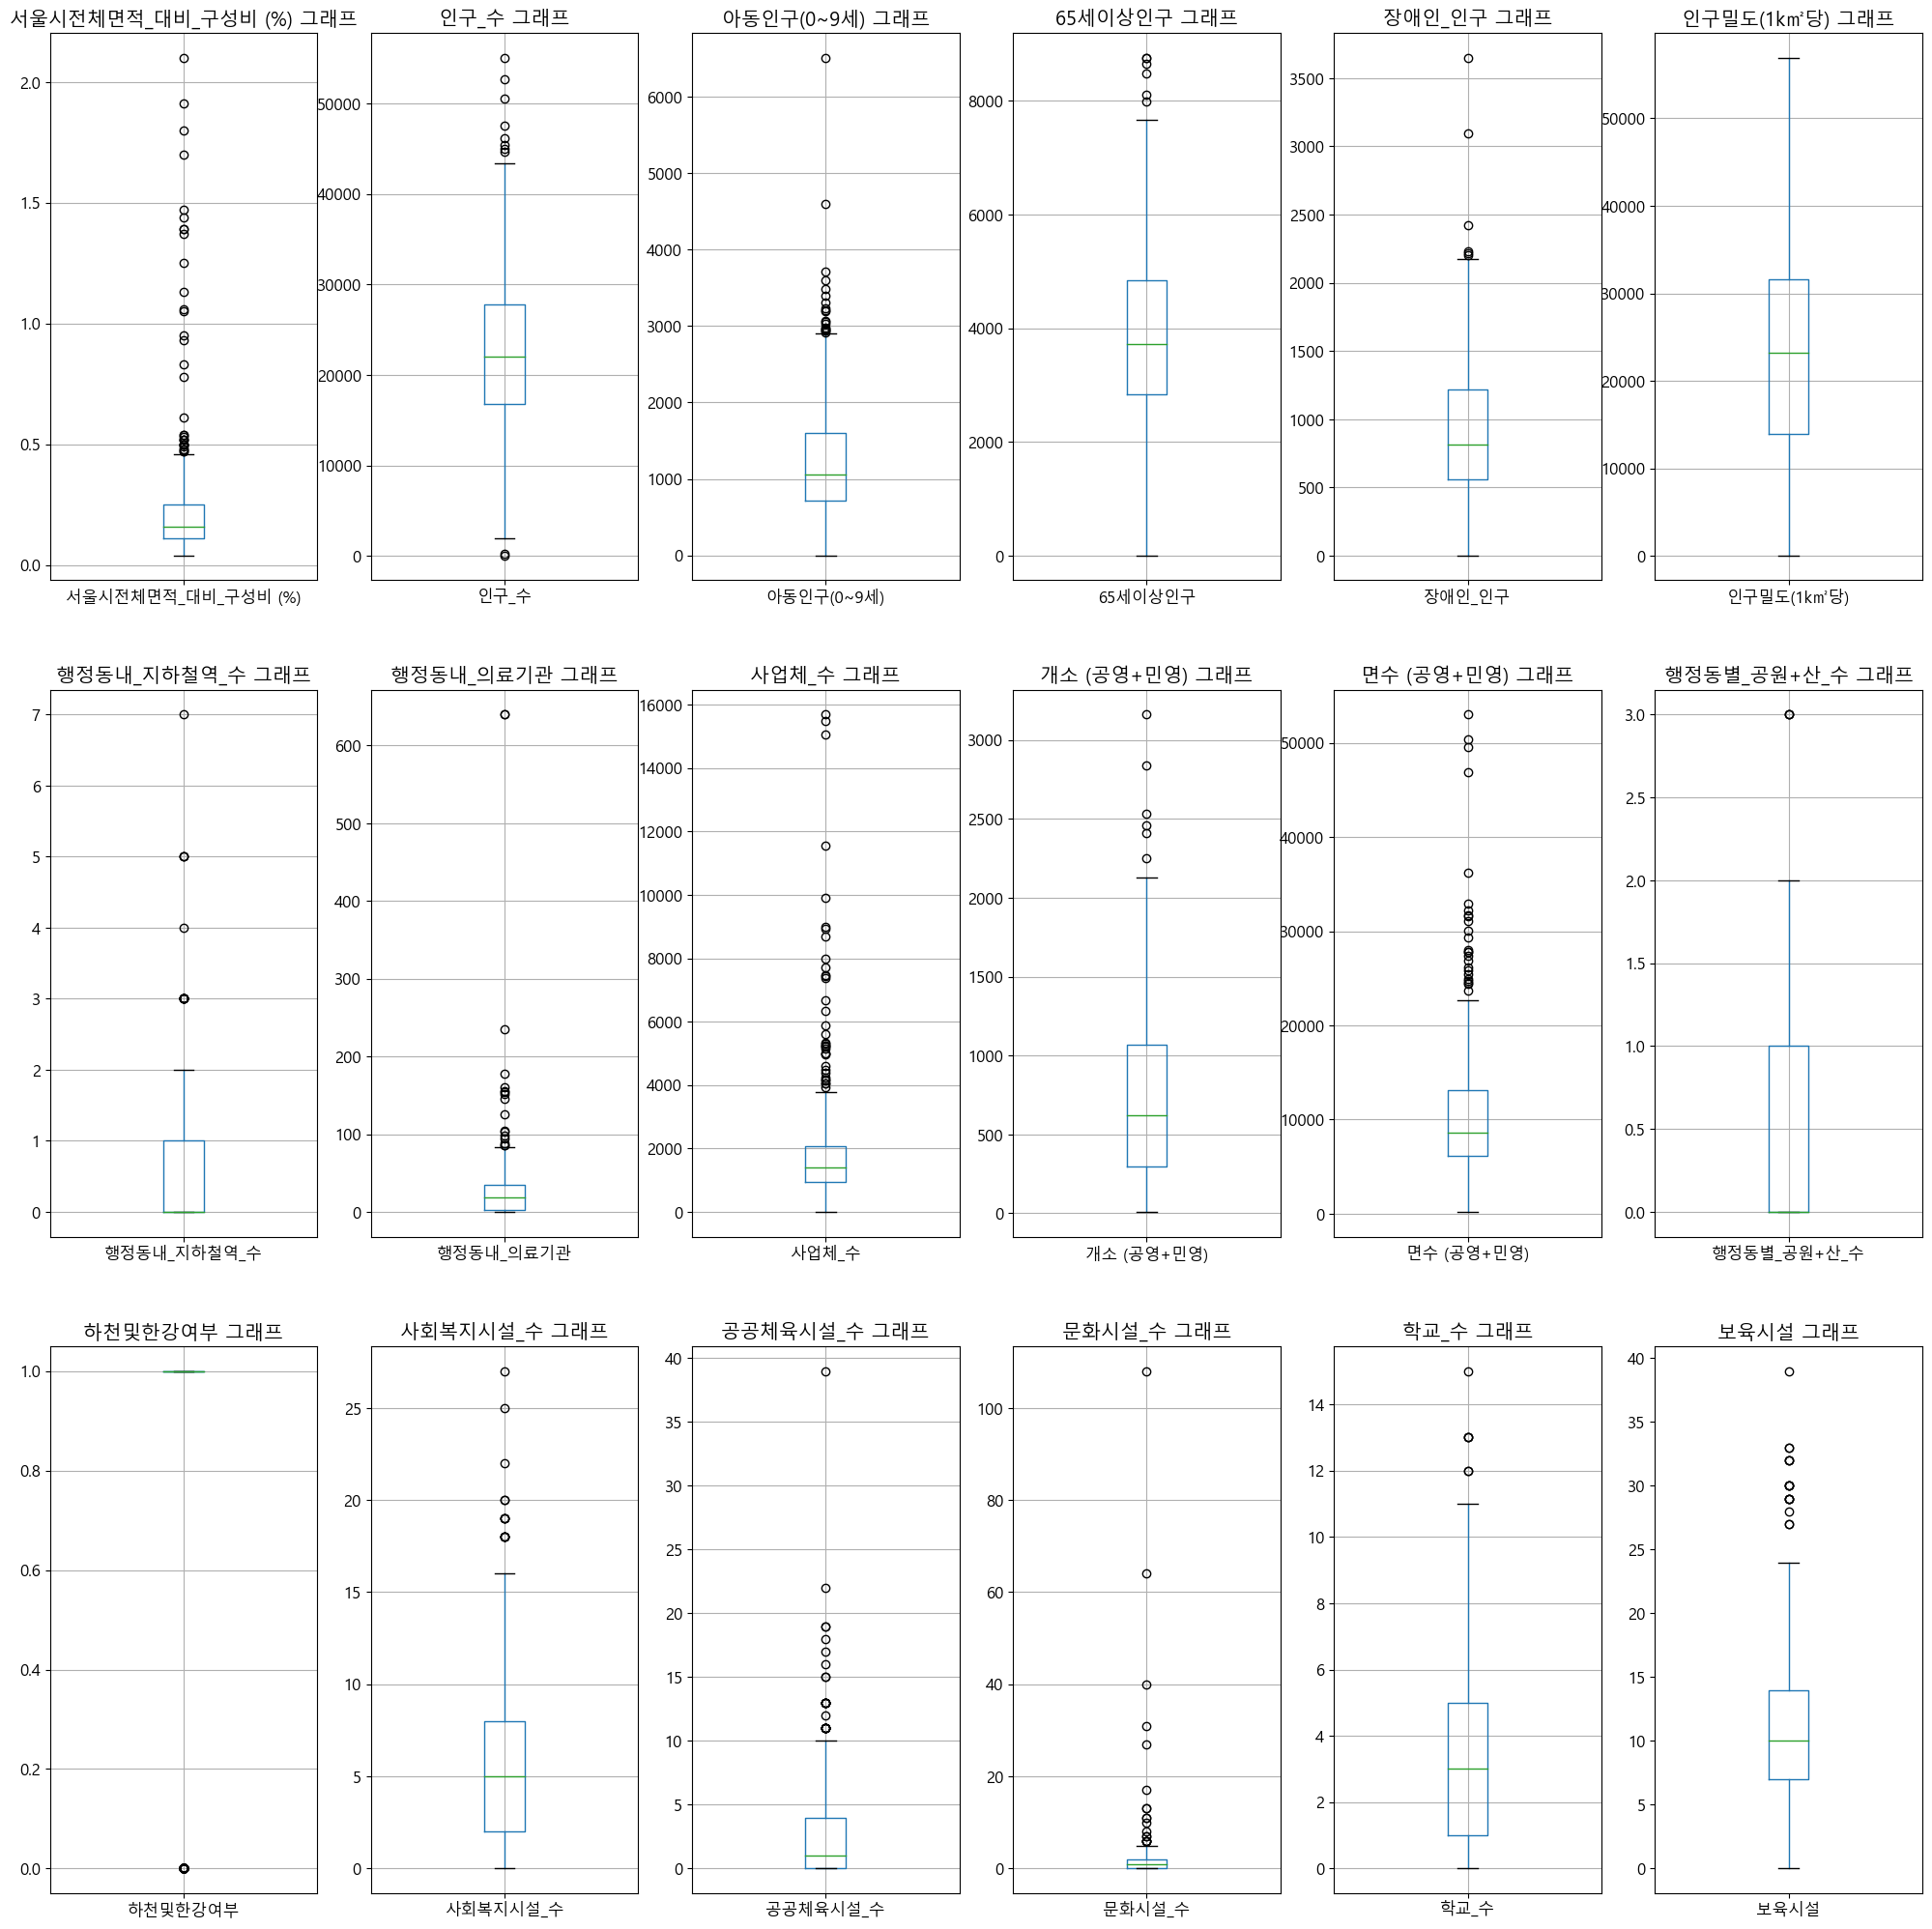

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(25, 25))
for i, c in enumerate(columns):
    row, col = divmod(i, 6)
    df1.boxplot(column=c, ax=ax[row, col])
    ax[row, col].set_title(f"{c} 그래프")
    plt.grid()
plt.show()

> 이상치로 의심되는 값이 존재하지만 실제 조사값인 만큼 사용하기로 결정